## SageMaker Model Monitor (data quality) for SageMaker Batch Transform Jobs - Model Scoring Pipeline  Pipeline

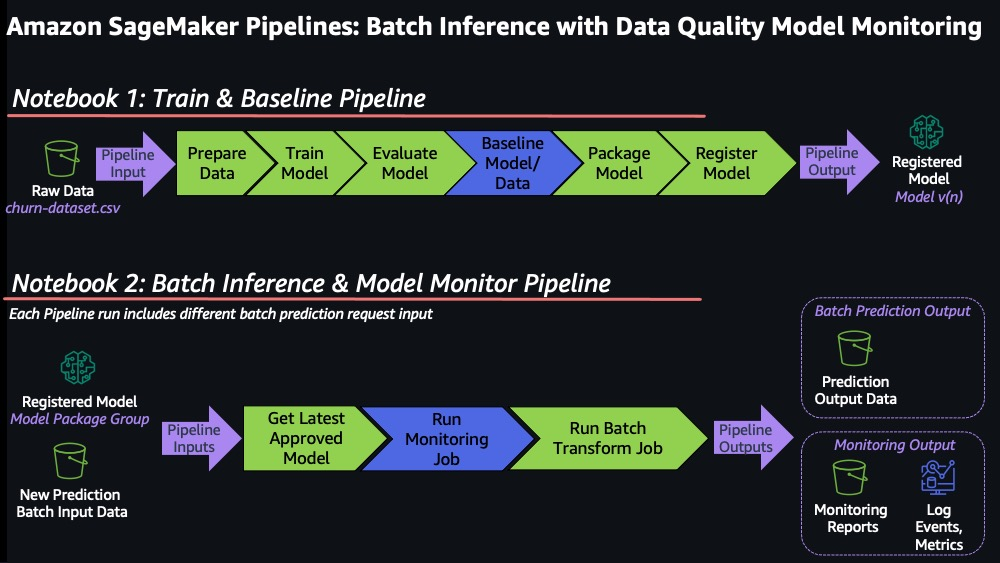


In [ ]:
#import sys

#! pip install --upgrade pip
#!{sys.executable} -m pip install sagemaker==2.114.0
#!{sys.executable} -m pip install -U boto3

In [ ]:
#If you run this notebook in SageMaker Studio, you need to make sure latest python SDK is installed and restart the kernel, 
#so please uncomment the code in the next cell, and run it.
#import IPython
#IPython.Application.instance().kernel.do_shutdown(True)  # has to restart kernel so changes are used

# Setup

In this section, we'll import libraries and setup variables needed to configure pipeline steps and construct the batch scoring & monitoring pipeline. 

In [ ]:
import os
import boto3
import re
import time
from time import gmtime, strftime
import json
import pandas as pd
import sagemaker

# SageMaker Job Imports (ex. Processing, Batch Inference) 
from sagemaker.transformer import Transformer
from sagemaker.image_uris import retrieve

# SageMaker Pipeline Imports 
from sagemaker.workflow.pipeline_context import PipelineSession
from sagemaker.workflow.model_step import ModelStep

from sagemaker.workflow.lambda_step import (
    LambdaStep,
    LambdaOutput,
    LambdaOutputTypeEnum,
)
from sagemaker.lambda_helper import Lambda

from sagemaker.workflow.execution_variables import ExecutionVariables

from sagemaker.workflow.parameters import (
    ParameterBoolean,
    ParameterInteger,
    ParameterString,
)

from sagemaker.model_monitor import DefaultModelMonitor
from sagemaker.model_monitor.dataset_format import DatasetFormat
from sagemaker.workflow.check_job_config import CheckJobConfig
from sagemaker.workflow.quality_check_step import DataQualityCheckConfig

from sagemaker.workflow.steps import CacheConfig

In [ ]:
region = boto3.Session().region_name
pipeline_session = PipelineSession()
aws_account_id = boto3.client('sts').get_caller_identity().get('Account')
role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

In [ ]:
bucket = pipeline_session.default_bucket()
prefix = f"demo-model-monitor-batch-transform/{int(time.time())}"

batch_transform_output_path = "s3://{}/{}/batch-transform-outputs".format(bucket, prefix)
batch_monitor_reports_output_path = "s3://{}/{}/data-quality-monitor-reports".format(bucket, prefix)


print("Batch Transform Output path: {}".format(batch_transform_output_path))
print("Batch Transform Data Drift Monitoring Output path: {}".format(batch_monitor_reports_output_path))

## 2. Configure Model Deploy & Monitor Pipeline Steps

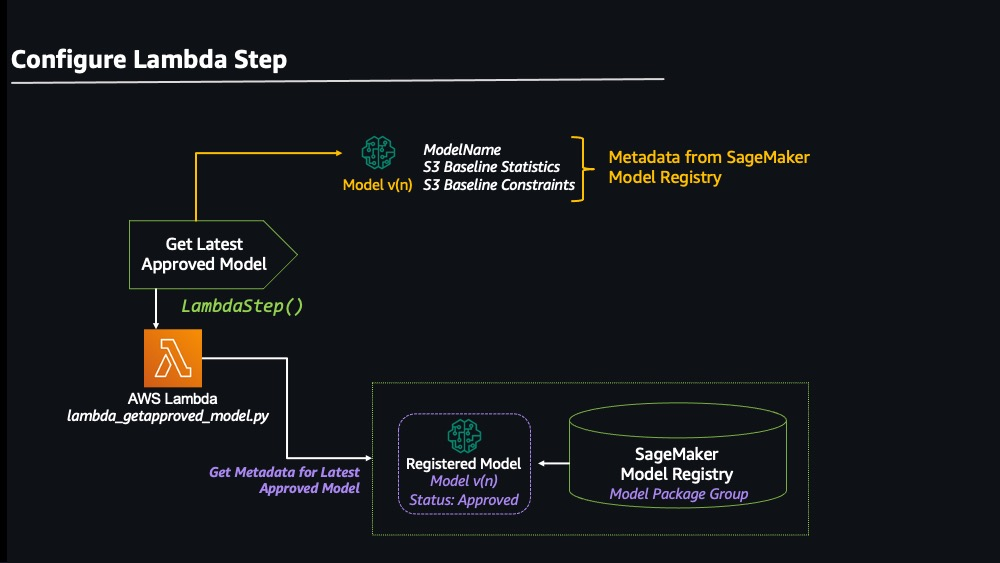

### 2-A. Create Lambda Function Code

In order to get the latest approved model we will need a Lambda function to query the Model Registry. This Lambfa function will output the Model Package ARN, basline statistics and constraints S3 URI that was created in part 1. 

In [ ]:
%%writefile lambda_getapproved_model.py

"""
This Lambda function queries SageMaker Model Registry for a specific model package 
group provided on input to identify the latest approved model version and return related metadata. 
The output includes: 
(1) model package arn (2) packaged model name (3) S3 URI for statistics baseline 
(4) S3 URI for constraints baseline  
The output is then used as input into the next step in the pipeline that
performs batch monitoring and scoring using the latest approved model. 
"""

import json
import boto3
from botocore.exceptions import ClientError

import logging
import os

def lambda_handler(event, context):
    """ """
    sm_client = boto3.client("sagemaker")
    logger = logging.getLogger()
    logger.setLevel(os.getenv("LOGGING_LEVEL", logging.INFO))

    # The model package group name
    model_package_group_name = event["model_package_group_name"]
    print(model_package_group_name)
    
    try:

        approved_model_response = sm_client.list_model_packages(
            ModelPackageGroupName=model_package_group_name,
            ModelApprovalStatus="Approved",
            SortBy="CreationTime"
        )
        
        model_package_arn = approved_model_response["ModelPackageSummaryList"][0]["ModelPackageArn"]
        logger.info(f"Identified the latest approved model package: {model_package_arn}")
        
        s3_baseline_uri_response = sm_client.describe_model_package(
            ModelPackageName=model_package_arn        
        )
        
        s3_baseline_uri_statistics = s3_baseline_uri_response["ModelMetrics"]["ModelDataQuality"]["Statistics"]["S3Uri"]
        s3_baseline_uri_constraints = s3_baseline_uri_response["ModelMetrics"]["ModelDataQuality"]["Constraints"]["S3Uri"]
        model_name = s3_baseline_uri_response["CustomerMetadataProperties"]["ModelName"]
        
        logger.info(f"Identified the latest data quality baseline statistics for approved model package: {s3_baseline_uri_statistics}")
        logger.info(f"Identified the latest data quality baseline constraints for approved model package: {s3_baseline_uri_constraints}")
        
        return {
        "statusCode": 200,
        "modelArn": model_package_arn,
        "s3uriConstraints": s3_baseline_uri_constraints,
        "s3uriStatistics": s3_baseline_uri_statistics,
        "modelName": model_name
        }

    
    except ClientError as e:
        error_message = e.response["Error"]["Message"]
        logger.error(error_message)
        raise Exception(error_message)

### Create & Configure the Lambda Pipeline Step

Once we have the Lambda function python script we can then use the SageMaker Python SDK `LambdaStep` to create a Lambda function as part of the pipeline. The `Lambda` helper class points to the python script and Lambda configurations which is used by the `LambdaStep`. 

In [ ]:


lambda_role_arn = f"arn:aws:iam::{aws_account_id}:role/Lambda-SageMaker-GetModelRole"
lambda_role_arn


In [ ]:
# Use the current time to define unique names for the resources created
current_time = time.strftime("%m-%d-%H-%M-%S", time.localtime())
function_name = "getapprovedmodel-sagemaker-step" + current_time


# This value should be changed to match the name of your model package group 
model_package_group_name = "customer-churn"

# Lambda helper class can be used to create the Lambda function
func = Lambda(
    function_name=function_name,
    execution_role_arn=lambda_role_arn,
    script="lambda_getapproved_model.py",
    handler="lambda_getapproved_model.lambda_handler",
    timeout=600,
    memory_size=128,
)

# The dictionary retured by the Lambda function is captured by LambdaOutput, each key in the dictionary corresponds to a
# LambdaOutput

output_param_1 = LambdaOutput(output_name="statusCode", output_type=LambdaOutputTypeEnum.String)
output_param_2 = LambdaOutput(output_name="modelArn", output_type=LambdaOutputTypeEnum.String)
output_param_3 = LambdaOutput(output_name="s3uriConstraints", output_type=LambdaOutputTypeEnum.String)
output_param_4 = LambdaOutput(output_name="s3uriStatistics", output_type=LambdaOutputTypeEnum.String)
output_param_5 = LambdaOutput(output_name="modelName", output_type=LambdaOutputTypeEnum.String)

lambda_getmodel_step = LambdaStep(
    name="LambdaStepGetApprovedModel",
    lambda_func=func,
    inputs={
        "model_package_group_name": model_package_group_name
     },
    outputs=[output_param_1, output_param_2,output_param_3,output_param_4,output_param_5])

![Step2](images/AIM321-Deploy-Monitor.jpg)

### 2-B. Setup Runtime Pipeline Parameter for Batch Transform & Monitor Step

This batch deployment & data quality monitoring pipeline will take the *s3://* uri of the batch prediction input data on input.  This is parameterized to allow for each run of the pipeline to include a new input dataset. 

In [ ]:
# The line below will run the pipeline using clean input - doesn't generate violations
#batch_prediction_data = "s3://aws-ml-blog/artifacts/ml_workshop/AIM321/churn-prediction-input.csv"

# The line below is using input that has been modified to having values out of range and missing
batch_prediction_data = "s3://aws-ml-blog/artifacts/ml_workshop/AIM321/churn-prediction-input-missing.csv"
batch_prediction_data

#batch_prediction_data = "s3://sagemaker-us-east-1-550263679080/aim321-demo-model-monitor-batch-transform/batch_prediction/churn-prediction-input-missing.csv"
#batch_prediction_data



We make use of `ParameterString` in the Pipeline in order to parameterize the Pipeline to take input data as a parameter. 

In [ ]:
transform_input_param = ParameterString(
    name="transform_input",
    default_value=batch_prediction_data,
)

### Configure a transformer for SageMaker Batch Transform Job

In order to add Transform Job to the Pipeline there is some configration we need to set up. We set the Batch Transform Job specifications such as the instance_type and instance_count in the `Transfomer`. 
For all available options take a look at the [`Transfomer` docs](https://sagemaker.readthedocs.io/en/stable/api/inference/transformer.html#transformer).

We are also joining the first all rows from the first column of the input to the output. Take a look at [Associating Prediction Results with Input Records](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform-data-processing.html#data-processing-operators) for more information.


In [ ]:
transformer = Transformer(
    model_name=lambda_getmodel_step.properties.Outputs["modelName"],
    instance_count=1,
    instance_type="ml.m5.xlarge",
    accept="text/csv",
    assemble_with="Line",
    output_path=batch_transform_output_path,
    sagemaker_session=pipeline_session,
)

In [ ]:
transform_arg = transformer.transform(
    transform_input_param,
    content_type="text/csv",
    split_type="Line",
    input_filter="$[1:]",
)

### Configure the data quality monitor for the SageMaker Batch Transform Job

The data quality monitor accepts the S3 URI of the baseline statistics and constraints specific to the approved model version from SageMaker Model Registry.  The baseline is then used to run the data quality monitoring job during pipeline execution comparing the batch prediction input data with baseline data to identify any violations signaling potential data drift. 

In [ ]:
job_config = CheckJobConfig(role=role)
data_quality_config = DataQualityCheckConfig(
    baseline_dataset=transform_input_param,
    dataset_format=DatasetFormat.csv(header=False),
    output_s3_uri=batch_monitor_reports_output_path,
)

### Use the `MonitorBatchTransformStep` to run & monitor the transform job

This step runs a batch transform job using the transformer object configured above and monitors the data passed to the transformer before executing the job.

**Note:** You can configure the step to fail if a violation to Data Quality is found by toggling the `fail_on_violation` flag.

In [ ]:
from sagemaker.workflow.monitor_batch_transform_step import MonitorBatchTransformStep

transform_and_monitor_step = MonitorBatchTransformStep(
    name="MonitorCustomerChurnDataQuality",
    transform_step_args=transform_arg,
    monitor_configuration=data_quality_config,
    check_job_configuration=job_config,
    monitor_before_transform=True,
    # if violation is detected in the monitoring, you can skip it and continue running batch transform
    fail_on_violation=False,
    supplied_baseline_statistics=lambda_getmodel_step.properties.Outputs["s3uriStatistics"],
    supplied_baseline_constraints=lambda_getmodel_step.properties.Outputs["s3uriConstraints"],
)

![Pipeline](./images/AIM321-Deploy-Create-Pipeline.jpg)

In [ ]:
from sagemaker.workflow.pipeline import Pipeline

pipeline_name = 'sagemaker-batch-inference-monitor'

batch_monitor_pipeline = Pipeline(
    name=pipeline_name,
    parameters=[transform_input_param],
    steps=[
        lambda_getmodel_step, 
        transform_and_monitor_step
    ],
)

Note: In order for the LambdaStep to sucesfully run, the model in the Model Registry needs to be approved. 

Please take a look at this the [Update the Approval Status of a Model](https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry-approve.html) for details on how to approve the model in the Model Reigstry. 

In [ ]:
batch_monitor_pipeline.upsert(role_arn=role)

### Start a pipeline execution

In [ ]:
execution = batch_monitor_pipeline.start()

## 2-C. Read the model monitor reports

You must wait for the pipeline to finish executing before you can read the violation reports.

This pipeline succeeds even though violations are found by model monitor because `fail_on_violation` is set to `False`.

![Step2](./images/AIM321-Monitor-Output-1.jpg)

## Constraints Violations S3 Report: *constraints_violations.json*

In [ ]:
sm_client = boto3.client("sagemaker")
import time

while True:
    
    status = sm_client.describe_pipeline_execution(
        PipelineExecutionArn=execution.arn
    )['PipelineExecutionStatus']
    

    if status != "Succeeded":
        print(f"Pipeline in status: {status}")
    else:
        print(f"Pipeline in status: {status}")
        status = response['PipelineExecutionStatus']

        from sagemaker.model_monitor import MonitoringExecution

        monitoring_step = [step for step in execution.list_steps() if "QualityCheck" in step["Metadata"]][0]

        monitoring = MonitoringExecution.from_processing_arn(
            sagemaker_session=pipeline_session,
            processing_job_arn=monitoring_step["Metadata"]["QualityCheck"]["CheckJobArn"],
        )

        violation = monitoring.constraint_violations(file_name="constraint_violations.json")
        break
        
    time.sleep(30)


In [ ]:
pd.set_option("display.max_colwidth", 1)

constraints_df = pd.json_normalize(violation.body_dict["violations"])
constraints_df.head(10)

## View CloudWatch Logs

Incorporate alerts and/or retraining based on violations found during the monitoring job.  When violations are found, SageMaker's managed model monitor container will emit a message to AWS CloudWatch logs.  

In [ ]:
cw_logs_client = boto3.client('logs')

response = cw_logs_client.describe_log_streams(
    logGroupName='/aws/sagemaker/ProcessingJobs',
    logStreamNamePrefix=monitoring.job_name.split("monitorcustomerchurn")[0],
    
)


In [ ]:

log_group = '/aws/sagemaker/ProcessingJobs'
log_stream_name = [response['logStreams'][0]['logStreamName']]


query = f"CompletedWithViolations"

violations_query_response = cw_logs_client.filter_log_events(
    logGroupName=log_group,
    logStreamNames = log_stream_name,
    filterPattern="CompletedWithViolations"
)

In [ ]:
violations_query_response

## Handling Monitoring Violations

![Violations](./images/AIM321-Handling-Violations-1.jpg)